twitter.com/0x94305

This notebook models the loss of LPs to arbitrageurs as a function of (1) price volatility, (2) block time, and (3) swap fees 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker
import seaborn as sns
from math import sqrt
from numba import njit, float64
from numba.experimental import jitclass

In [2]:
spec = [
    ('sqrtP', float64),  # this might need to be changed to float32, depending on setup (also in the import above)
    ('L', float64),
    ('Fee', float64)
]

@jitclass(spec)
class AMM:

     def __init__(self, fee=0.0, p = 1200.0, L = 166_666.67):
         """Constructor, instantiates a new AMM pool

         Args:
             fee (float, optional): Pool fee. Defaults to 0.0.
             p (float, optional): Price of token X (eg ETH) in token Y (eg USDT). Defaults to 1200.0.
             L (_type_, optional): Marginal liquidity.
                Defaults to 166_666.67, which is approx 20,000 Y/bps at p=1200.
                In general, to get a realistic L, get liquidity/bps from a Uniswap pool (x),
                and set L=x*10^4/p
         """
         self.sqrtP = sqrt(p)
         self.L = L
         self.Fee = 1 + fee


     def xReserves(self):
         """Gets reserves of X (base) token from the pool.

         The reserves do not include fees and are calculated in Uniswap v2-equivalent units (ambient liquidity).

         Returns:
             float: Reserves of X
         """
         return self.L/self.sqrtP

     def yReserves(self):
         """Gets reserves of Y (quote) token from the pool. 

         The reserves do not include fees and are calculated in Uniswap v2-equivalent units (ambient liquidity).

         Returns:
             float: Reserves of Y
         """        
         return self.L*self.sqrtP

     def tradeToPriceWithFee(self, targetP, gas=0.0):
         """Attempts to perform an arbitrage swap given the target price.

         Args:
             targetP (float): target "efficient" price. If it exceeds the current pool price of X, 
                the function will attempt to buy X for the client (the pool will be selling X).
                The swap must be profitable to the client after the swap fee and gas cost. 
             gas (float, optional): total gas cost of the transaction in Y tokens. Defaults to 0.0.

         Returns:
             x, y, fee: If a profitable arbitrage opportunity is found, then it is executed
                against the pool. The return values of x and y are positive if the client receives 
                the corresponding amount and negative otherwise. x and y already include the swap fee,
                but not gas cost. fee is reported for informational purposes and is measured in Y tokens.
                If no profitable swap is found, the state of the pool is unchanged, and the function 
                returns three zeros. 
         """
         currentP = self.sqrtP**2

         if (self.Fee*currentP > targetP) and (currentP*(2 - self.Fee) < targetP):
            # target price is within the current bid-ask spread, no arb opportunity available
            (x, y, fee) = (0,0,0)
            newSqrtP = self.sqrtP
         elif (self.Fee*currentP < targetP):
            # target price is higher than best ask, try buying X for the client (the pool sells)
            newSqrtP = sqrt(targetP / self.Fee)
            y = -(newSqrtP - self.sqrtP)*self.L
            (x, y, fee) = ((newSqrtP-self.sqrtP)*self.L/(self.sqrtP*newSqrtP),
             y*self.Fee, -y*(self.Fee-1))
         else:
            newSqrtP = sqrt(targetP / (2 - self.Fee))
            y = -(newSqrtP - self.sqrtP)*self.L
            (x, y, fee) = ((newSqrtP-self.sqrtP)*self.L/(self.sqrtP*newSqrtP),
             y*(2 - self.Fee), (y-y*(2 - self.Fee)))

         if (x*targetP + y < gas):
            (x, y, fee) = (0.0, 0.0, 0.0) 
         else:
            self.sqrtP = newSqrtP

         return (x, y, fee)


In [18]:
@njit
def run_simulations(fee, daily_std, blocks_per_day, days, paths, gas_fee):
    # This array will store two values for each simulated price path:
    # lvr (as a positive number), arb's gain (negative)
    results = np.zeros((2, paths))
    
    for jj in range(paths):
        amm1 = AMM(fee, 1200.0, 166_666.67)
        
        # save the initial price
        p0 = amm1.sqrtP**2
        
        sigma = daily_std/np.sqrt(blocks_per_day) # vol between blocks
        T = int(days*blocks_per_day)

        # Generate a GBM path for prices
        z = np.cumsum(np.random.normal(0.0, sigma, T))
        # Note that we are adding a risk-neutral drift, so that the price process is a martingale
        prices = np.exp(z-(np.arange(T)*sigma**2)/2)
        prices = prices/prices[0]*p0

        # save the initial reserves   
        initial_yReserves = amm1.yReserves()

        lvr1 = arb_gain1 = 0.0
        
        for i in range(T):
            x0, y0, f = amm1.tradeToPriceWithFee(prices[i], gas_fee)
            lvr1 += -x0*prices[i] - y0
            if (x0!=0) or (y0!=0): arb_gain1 += x0*prices[i] + y0 - gas_fee

        results[:, jj] = [-x/days/(2*initial_yReserves) for x in [lvr1, arb_gain1]]

    return results

In [19]:
# Set default parameters here
fee = 0.0030 #swap fee
daily_std = 0.05 # daily std of the price of X in Y
blocks_per_day = 24.0*60*600 # 600 blocks per minute = 100ms blocks
days = 1.0 # how many days each simulation runs
paths = 1000 # how many price paths to simulate. days*paths = total number of simulated days
gas_fee = 0.0

In [20]:
# Run simulations changing one parameter at a time, i.e., start with fees
results1 = run_simulations(fee, daily_std, blocks_per_day, days, paths, gas_fee)
results2 = run_simulations(0.0015, daily_std, blocks_per_day, days, paths, gas_fee)
results3 = run_simulations(0.0005, daily_std, blocks_per_day, days, paths, gas_fee)


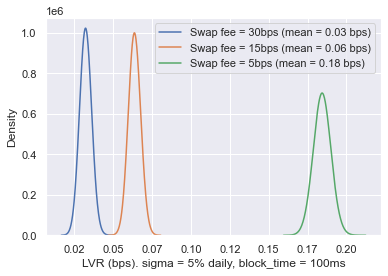

In [25]:
# Now we can plot the results

sns.set()
bw_adjust = 5
means = [np.mean(s) for s in [results1[0,:], results2[0,:], results3[0,:]]]

ax = sns.kdeplot(data=results1[0,:], bw_adjust=bw_adjust, label = 
"Swap fee = 30bps (mean = {:.2f} bps)".format(means[0]*10000))

ax = sns.kdeplot(data=results2[0,:], bw_adjust=bw_adjust, label = 
"Swap fee = 15bps (mean = {:.2f} bps)".format(means[1]*10000))

ax = sns.kdeplot(data=results3[0,:], bw_adjust=bw_adjust, label = 
"Swap fee = 5bps (mean = {:.2f} bps)".format(means[2]*10000))

ax.set(xlabel="LVR (bps). sigma = 5% daily, block_time = 100ms", ylabel='Density')
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels(["{:.2f}".format(tick*10000) for tick in ticks_loc])

plt.legend()
plt.show()


In [26]:
# Now keep fee at 5bps, and change sigma
results1 = run_simulations(0.0005, daily_std/2, blocks_per_day, days, paths, gas_fee)
results2 = run_simulations(0.0005, daily_std, blocks_per_day, days, paths, gas_fee)
results3 = run_simulations(0.0005, daily_std*2, blocks_per_day, days, paths, gas_fee)

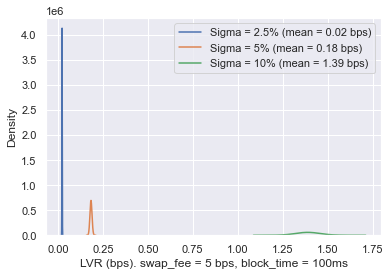

In [27]:

sns.set()
bw_adjust = 5
means = [np.mean(s) for s in [results1[0,:], results2[0,:], results3[0,:]]]

ax = sns.kdeplot(data=results1[0,:], bw_adjust=bw_adjust, label = 
"Sigma = 2.5% (mean = {:.2f} bps)".format(means[0]*10000))

ax = sns.kdeplot(data=results2[0,:], bw_adjust=bw_adjust, label = 
"Sigma = 5% (mean = {:.2f} bps)".format(means[1]*10000))

ax = sns.kdeplot(data=results3[0,:], bw_adjust=bw_adjust, label = 
"Sigma = 10% (mean = {:.2f} bps)".format(means[2]*10000))

ax.set(xlabel="LVR (bps). swap_fee = 5 bps, block_time = 100ms", ylabel='Density')
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels(["{:.2f}".format(tick*10000) for tick in ticks_loc])

plt.legend()
plt.show()


In [30]:
means[1]/means[0], means[2]/means[1]

(7.771063145241111, 7.54250895043197)

In [31]:
# Now keep fee at 5bps, and change sigma
results1 = run_simulations(0.0005, daily_std, blocks_per_day, days, paths, gas_fee)
results2 = run_simulations(0.0005, daily_std, blocks_per_day/4, days, paths, gas_fee)
results3 = run_simulations(0.0005, daily_std, blocks_per_day/16, days, paths, gas_fee)

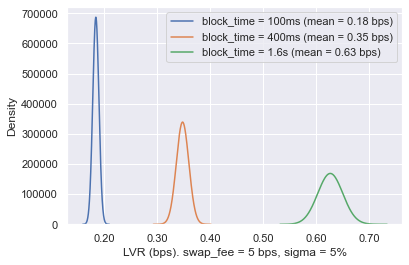

In [33]:
sns.set()
bw_adjust = 5
means = [np.mean(s) for s in [results1[0,:], results2[0,:], results3[0,:]]]

ax = sns.kdeplot(data=results1[0,:], bw_adjust=bw_adjust, label = 
"block_time = 100ms (mean = {:.2f} bps)".format(means[0]*10000))

ax = sns.kdeplot(data=results2[0,:], bw_adjust=bw_adjust, label = 
"block_time = 400ms (mean = {:.2f} bps)".format(means[1]*10000))

ax = sns.kdeplot(data=results3[0,:], bw_adjust=bw_adjust, label = 
"block_time = 1.6s (mean = {:.2f} bps)".format(means[2]*10000))

ax.set(xlabel="LVR (bps). swap_fee = 5 bps, sigma = 5%", ylabel='Density')
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels(["{:.2f}".format(tick*10000) for tick in ticks_loc])

plt.legend()
plt.show()

In [34]:
# Lastly, let's try close-to-Ethereum block times
blocks_per_day = 24*60*5
results1 = run_simulations(fee, daily_std, blocks_per_day, days, paths, gas_fee)
results2 = run_simulations(0.0015, daily_std, blocks_per_day, days, paths, gas_fee)
results3 = run_simulations(0.0005, daily_std, blocks_per_day, days, paths, gas_fee)

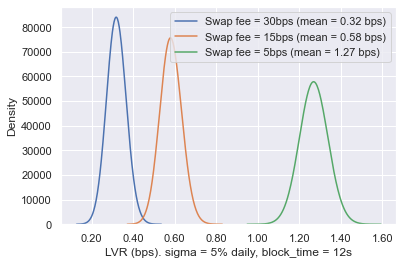

In [35]:
# Now we can plot the results

sns.set()
bw_adjust = 5
means = [np.mean(s) for s in [results1[0,:], results2[0,:], results3[0,:]]]

ax = sns.kdeplot(data=results1[0,:], bw_adjust=bw_adjust, label = 
"Swap fee = 30bps (mean = {:.2f} bps)".format(means[0]*10000))

ax = sns.kdeplot(data=results2[0,:], bw_adjust=bw_adjust, label = 
"Swap fee = 15bps (mean = {:.2f} bps)".format(means[1]*10000))

ax = sns.kdeplot(data=results3[0,:], bw_adjust=bw_adjust, label = 
"Swap fee = 5bps (mean = {:.2f} bps)".format(means[2]*10000))

ax.set(xlabel="LVR (bps). sigma = 5% daily, block_time = 12s", ylabel='Density')
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels(["{:.2f}".format(tick*10000) for tick in ticks_loc])

plt.legend()
plt.show()